In [2]:
# TensorFlow libraries
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# basic libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import glob
from glob import glob

In [9]:
# the path to the image data
RSNA_512_path = '/kaggle/input/rsna-breast-cancer-512-pngs'

In [10]:
# Read the csv data.
df_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [11]:
# The not-malignant cancer cases were limited into biopsy cases.
DF_train = df_train[df_train['biopsy'] == 1].reset_index(drop = True)
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,1,10102,453020471,R,CC,40.0,0,1,0,0.0,0,B,49,True
1,1,10102,1181635673,R,MLO,40.0,0,1,0,0.0,0,B,49,True
2,1,10102,1241778584,R,MLO,40.0,0,1,0,0.0,0,B,49,True
3,1,10102,1951607544,R,CC,40.0,0,1,0,0.0,0,B,49,True
4,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False


In [15]:
print(DF_train['cancer'].value_counts())
print('Data Size:', DF_train.shape[0])

0    1811
1    1158
Name: cancer, dtype: int64
New Data Size: 2969


In [16]:
# The number of positive (malignant) and negative (not-malignat) cases should be the same
# to create a balanced dataset.
DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample(1158, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', DF_train.shape[0])

New Data Size: 2316


In [28]:
print(DF_train['cancer'].value_counts())

0    1158
1    1158
Name: cancer, dtype: int64


# Create the Path to Each Image

In [19]:
from tqdm import tqdm  # Import tqdm for progress bar

for i in tqdm(range(len(DF_train)), desc='Adding file paths to DataFrame'):
    DF_train.loc[i, 'path'] = os.path.join(RSNA_512_path, f"{DF_train.loc[i, 'patient_id']}_{DF_train.loc[i, 'image_id']}.png")

DF_train.head()

Adding file paths to DataFrame: 100%|██████████| 2316/2316 [00:01<00:00, 1922.11it/s]


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,65309,2075270976,L,CC,44.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/6530...
1,1,12033,615051458,L,CC,42.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1203...
2,1,32340,1963534168,L,MLO,65.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3234...
3,1,27306,466876721,R,MLO,55.0,0,1,0,0.0,0,A,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2730...
4,1,36071,2063808894,R,MLO,59.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3607...


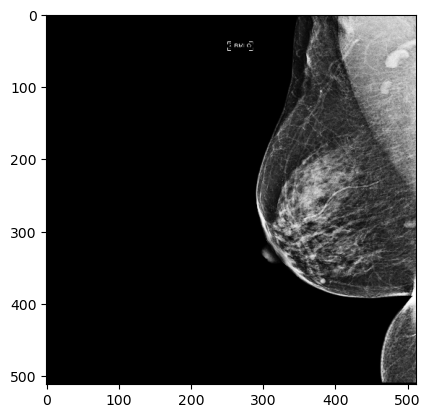

In [24]:
# a sample image
img = cv2.imread(DF_train.loc[4, 'path'])
plt.imshow(img, cmap = 'gray')

In [25]:
img

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [190, 190, 190],
        [189, 189, 189],
        [179, 179, 179]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 85,  85,  85],
        [107, 107, 107],
        [ 86,  86,  86]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [26]:
img.shape

(512, 512, 3)

In [27]:
# Normal and cancer images must be equally distrubuted.
train_df, val_df = train_test_split(DF_train, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = DF_train[['cancer']])

print('train', train_df.shape[0], 'validation', val_df.shape[0])
print('train', train_df['cancer'].value_counts())
print('validation', val_df['cancer'].value_counts())
train_df.sample(1)

train 1621 validation 695
train 1    811
0    810
Name: cancer, dtype: int64
validation 0    348
1    347
Name: cancer, dtype: int64


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
1947,1,55879,920069633,R,CC,48.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5587...


In [31]:
# Pick up normal images from the training data.
train_df_normal = train_df[train_df['cancer'] == 0].reset_index(drop = True)
print(len(train_df_normal))
train_df_normal.head()

810


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,36071,607232908,R,CC,59.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3607...
1,1,61590,1607157480,R,MLO,76.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/6159...
2,1,39209,65514512,R,CC,48.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3920...
3,1,9783,1944749001,R,CC,56.0,0,1,0,0.0,0,C,216,True,/kaggle/input/rsna-breast-cancer-512-pngs/9783...
4,1,44000,1658289641,L,CC,69.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4400...


In [32]:
# Pick up cancer images from the training data.
train_df_cancer = train_df[train_df['cancer'] == 1].reset_index(drop = True)
print(len(train_df_cancer))
train_df_cancer.head()

811


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,46225,1857969319,L,CC,63.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4622...
1,1,57754,168975717,L,CC,46.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5775...
2,2,7964,953630878,R,CC,67.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/7964...
3,2,15268,1398189039,R,MLO,62.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/1526...
4,1,10668,1774497291,R,MLO,53.0,1,1,1,0.0,0,C,170,False,/kaggle/input/rsna-breast-cancer-512-pngs/1066...


In [33]:
# Pick up normal images from the validation data.
val_df_normal = val_df[val_df['cancer'] == 0].reset_index(drop = True)
print(len(val_df_normal))
val_df_normal.head()

348


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,61840,1160847713,L,MLO,45.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/6184...
1,1,9611,1865891152,L,CC,51.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/9611...
2,1,46268,42598233,R,MLO,43.0,0,1,0,0.0,1,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4626...
3,1,54532,658623481,L,CC,51.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5453...
4,1,8742,819926265,R,CC,36.0,0,1,0,0.0,0,A,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/8742...


In [34]:
# Pick up cancer images from the validation data.
val_df_cancer = val_df[val_df['cancer'] == 1].reset_index(drop = True)
print(len(val_df_cancer))
val_df_cancer.head()

347


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,37213,221096123,R,MLO,72.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3721...
1,1,37032,1897605293,L,CC,76.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3703...
2,2,9167,436533616,L,CC,62.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/9167...
3,2,31864,873474308,L,MLO,73.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/3186...
4,1,28634,1562558660,R,MLO,74.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2863...


**We have to store the 4 datasets in each folder to be used for machine learing of TensorFlow AI model.**

In [35]:
import shutil
# Define the destination directory.
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/normal'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in train_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [36]:
# Define the destination directory.
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/cancer'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in train_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

In [37]:
# Define the destination directory.
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/normal'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in val_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [38]:
# Define the destination directory.
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/cancer'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in val_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

# Sample Images

In [41]:
import glob
normal_train_images = glob.glob('/kaggle/working/train/normal/*.png')
cancer_train_images = glob.glob('/kaggle/working/train/cancer/*.png')
print(len(normal_train_images))
print(len(cancer_train_images))

650
586


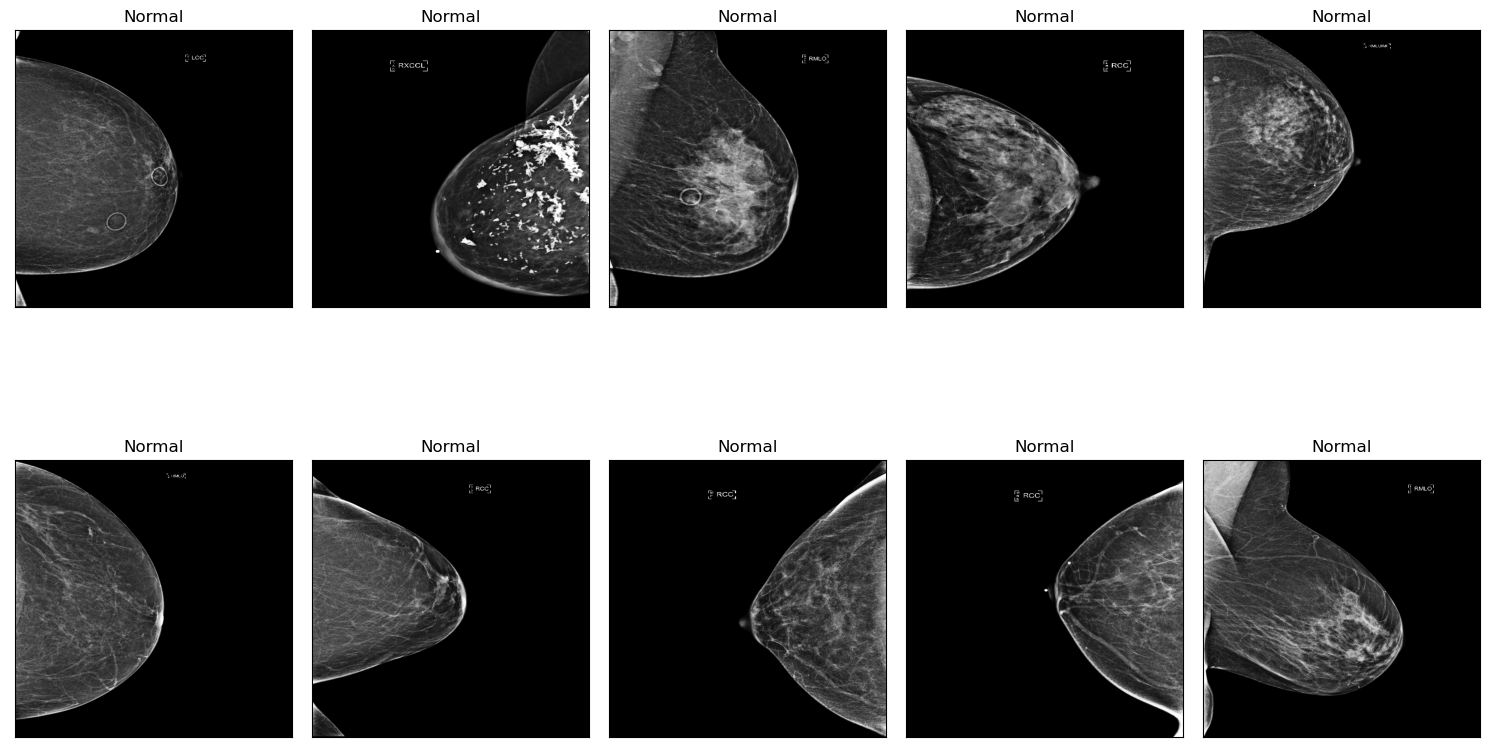

In [42]:
# See normal images from the training dataset.
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    ax.imshow(img)
    ax.set_title('Normal')
fig.tight_layout()    

plt.show()

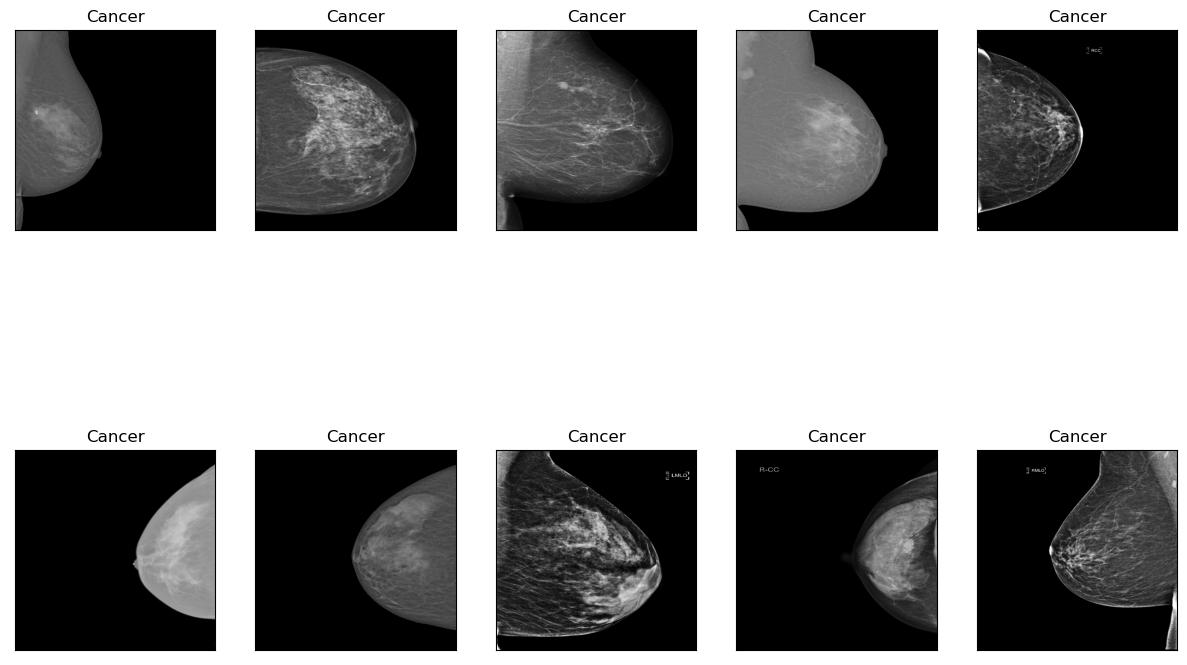

In [43]:
# See cancer images from the training dataset.
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(cancer_train_images[i])
    ax.imshow(img)
    ax.set_title('Cancer')
    
plt.show()

# Create Image data Generators

The dataset has already been divided into train and validation datasets, and each dataset includes normal and cancer image files. Thus, image data generators were easily created. 

In [44]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)

In [45]:
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size = (512, 512),
        batch_size = 16,
        class_mode = 'binary'
)

Found 1236 images belonging to 2 classes.
Found 616 images belonging to 2 classes.


# Define the Model (Transfer Learning)

Here, ResNet50V2 was employed as the base model for transfer learning. It would be also possible to conduct fine tuning with the model. The choice of hyperparameters depends on the type of task by machine learning. Sigmoid, adam, and binary cross entropy were selected for the final activation function, optimizer, and loss function, respectively.

In [46]:
base_model = ResNet50V2(include_top = False,weights = 'imagenet', input_shape = (512, 512, 3))

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

94668760/94668760 [==============================] - 4s 0us/step


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 262,401
Non-trainable params: 23,564,800
______________________________________

# Train the Model

The model was trained with the train and validation data. Early stopping was added to prevent overfitting. In fact, it might be preferable to set the larger number of epochs.

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 15, callbacks = callback)

Epoch 1/15
20/20 [==============================] - 54s 2s/step - loss: 0.7417 - accuracy: 0.5359 - val_loss: 0.6429 - val_accuracy: 0.6429
Epoch 2/15
20/20 [==============================] - 45s 2s/step - loss: 0.6467 - accuracy: 0.6162 - val_loss: 0.6163 - val_accuracy: 0.6656
Epoch 3/15
20/20 [==============================] - 44s 2s/step - loss: 0.6322 - accuracy: 0.6406 - val_loss: 0.6040 - val_accuracy: 0.6802
Epoch 4/15
20/20 [==============================] - 44s 2s/step - loss: 0.6018 - accuracy: 0.6797 - val_loss: 0.6036 - val_accuracy: 0.6802
Epoch 5/15
20/20 [==============================] - 43s 2s/step - loss: 0.6063 - accuracy: 0.6481 - val_loss: 0.6191 - val_accuracy: 0.6412
Epoch 6/15
20/20 [==============================] - 44s 2s/step - loss: 0.6246 - accuracy: 0.6250 - val_loss: 0.6069 - val_accuracy: 0.6542
Epoch 7/15
20/20 [==============================] - 43s 2s/step - loss: 0.6029 - accuracy: 0.6688 - val_loss: 0.6057 - val_accuracy: 0.6786
Epoch 8/15
20/20 [==

# Save the Model

In [49]:
model.save('mammography_pred_model.h5')

# Model Metrics

The accuracy and loss were calculated for both train and validation data in the model training process.

In [50]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing Accuracy and Loss

Text(0, 0.5, 'loss')

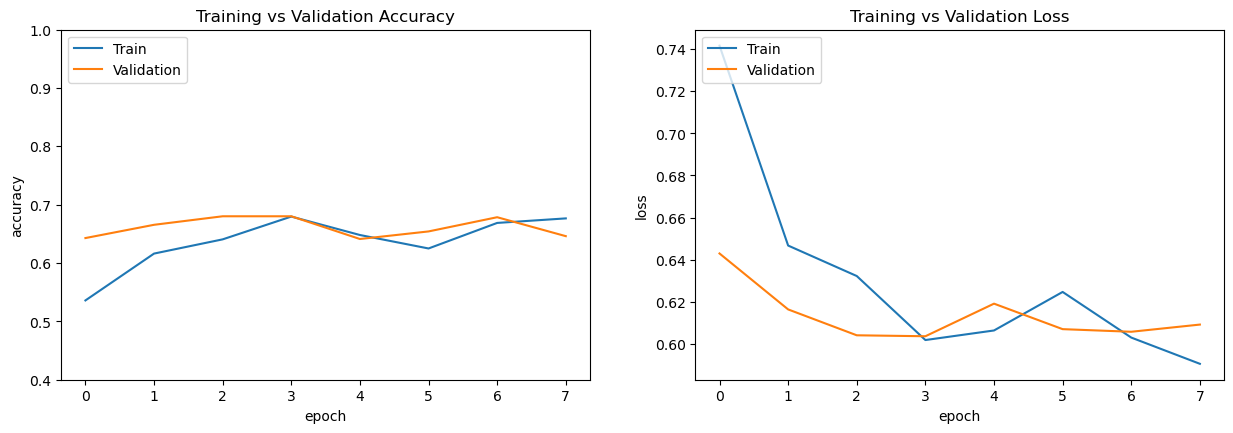

In [51]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

In [52]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/mammography_pred_model.h5')

In [53]:
pred = model.predict(validation_generator)

39/39 [==============================] - 8s 185ms/step


In [81]:
final_accuracy_1 = model.evaluate_generator(validation_generator)[1]
final_accuracy_1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.5275974273681641

In [54]:
# prediction by the AI
pred

array([[0.6681451 ],
       [0.07438226],
       [0.49732643],
       [0.6164092 ],
       [0.40290418],
       [0.29561767],
       [0.5476153 ],
       [0.06423753],
       [0.47422084],
       [0.47920948],
       [0.5157216 ],
       [0.7980987 ],
       [0.44296277],
       [0.5965955 ],
       [0.38871393],
       [0.7439182 ],
       [0.10775483],
       [0.06960455],
       [0.4908064 ],
       [0.6180073 ],
       [0.57721937],
       [0.43769524],
       [0.53868824],
       [0.69629866],
       [0.68341863],
       [0.7402144 ],
       [0.08965767],
       [0.25302663],
       [0.6216693 ],
       [0.58826554],
       [0.3033243 ],
       [0.5030833 ],
       [0.5776275 ],
       [0.86752343],
       [0.40516534],
       [0.31893396],
       [0.4824486 ],
       [0.20391342],
       [0.54537684],
       [0.7022864 ],
       [0.60064596],
       [0.6111095 ],
       [0.5434532 ],
       [0.57098216],
       [0.74689513],
       [0.24822485],
       [0.6034455 ],
       [0.649

In [55]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [56]:
print(y_pred)

[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 

In [57]:
pd.Series(y_pred).value_counts()

0    311
1    305
dtype: int64

In [58]:
y_true = validation_generator.classes

In [59]:
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [60]:
cm = confusion_matrix(y_true, y_pred)

In [62]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.47      0.46       291
           1       0.50      0.46      0.48       325

    accuracy                           0.47       616
   macro avg       0.47      0.47      0.47       616
weighted avg       0.47      0.47      0.47       616



# Analysing the Results

It is crucial in the medical field to analyze what kinds of cases were misclassified by the AI model, because medical misdiagnosis must be avoided as much as possible. Thus, it is necessary to identify false positive and false negative cases. Making a data frame and confusion table can visualize the results. As discussed above, false negative cases must be particularly avoided.

In [63]:
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [64]:
print(confusion)

['FP', 'TN', 'TN', 'FP', 'TN', 'TN', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'TN', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'TN', 'TN', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'TN', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'TN', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'TN', 'TN', 'TN', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'TN', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP

In [65]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table

,Results
0,FP
1,TN
2,TN
3,FP
4,TN
...,...
611,TP
612,FN
613,FN
614,FN


In [66]:
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,1,0,FP
1,0,0,TN
2,0,0,TN
3,1,0,FP
4,0,0,TN
...,...,...,...
611,1,1,TP
612,0,1,FN
613,0,1,FN
614,0,1,FN


In [67]:
confusion_table.Results == 'FP'

0       True
1      False
2      False
3       True
4      False
       ...  
611    False
612    False
613    False
614    False
615    False
Name: Results, Length: 616, dtype: bool

In [68]:
# list of false positive images
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
0,1,0,FP
3,1,0,FP
6,1,0,FP
10,1,0,FP
11,1,0,FP
...,...,...,...
282,1,0,FP
283,1,0,FP
285,1,0,FP
288,1,0,FP


In [69]:
FPs.index

Int64Index([  0,   3,   6,  10,  11,  13,  15,  19,  20,  22,
            ...
            275, 276, 277, 278, 280, 282, 283, 285, 288, 289],
           dtype='int64', length=154)

In [70]:
# list of false negative images
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results
291,0,1,FN
293,0,1,FN
296,0,1,FN
297,0,1,FN
299,0,1,FN
...,...,...,...
607,0,1,FN
609,0,1,FN
612,0,1,FN
613,0,1,FN


In [71]:
FNs.index

Int64Index([291, 293, 296, 297, 299, 303, 305, 307, 308, 309,
            ...
            598, 600, 602, 603, 606, 607, 609, 612, 613, 614],
           dtype='int64', length=174)

# Misclassficiation Cases

It is impoertant to pick up wrong cases judged by the AI and to analyze why the AI made wrong judgements for these images.

In [72]:
import glob
val_images = glob.glob('/kaggle/working/val/*/*.png')

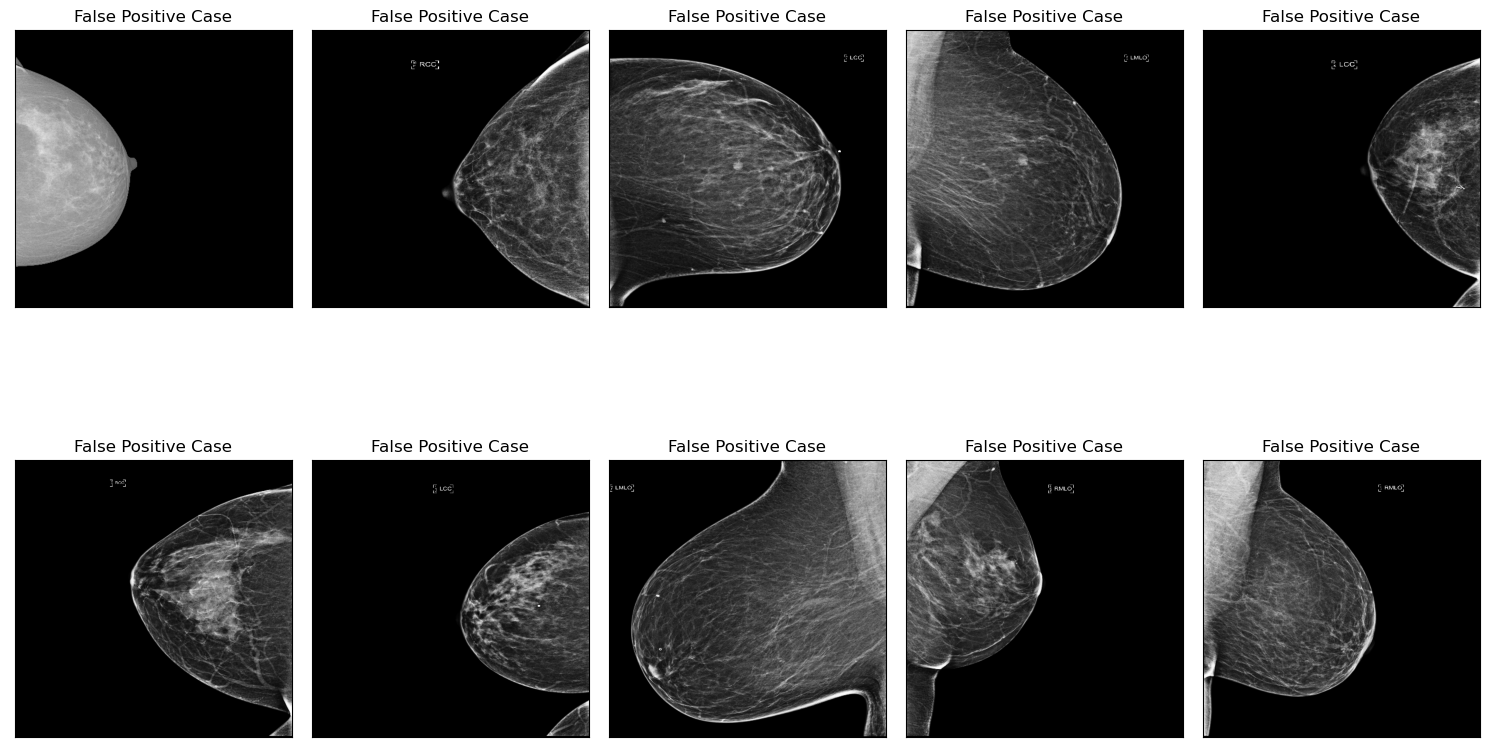

In [73]:
# False positive imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FPs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()    

plt.show()

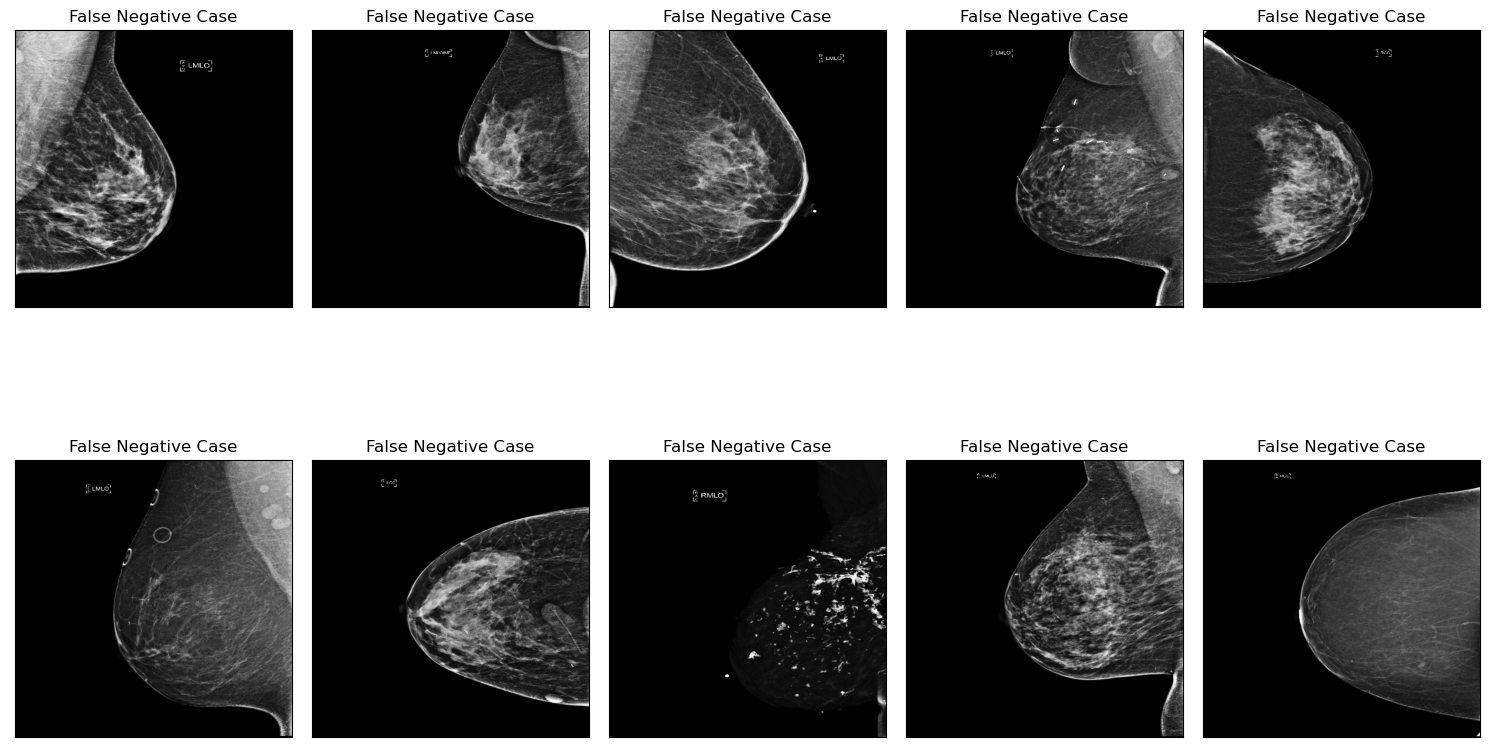

In [74]:
# False negative imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FNs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Negative Case")
fig.tight_layout()    

plt.show()

In [75]:
# Finetuning the model
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = True # Change from False to True.
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 23,781,761
Non-trainable params: 45,440
_____________________________________

In [77]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 15, callbacks = callback)

Epoch 1/15
20/20 [==============================] - 77s 2s/step - loss: 0.7601 - accuracy: 0.5796 - val_loss: 53.6574 - val_accuracy: 0.4286
Epoch 2/15
20/20 [==============================] - 48s 2s/step - loss: 0.6716 - accuracy: 0.5734 - val_loss: 845146.0000 - val_accuracy: 0.5276
Epoch 3/15
20/20 [==============================] - 47s 2s/step - loss: 0.6802 - accuracy: 0.5812 - val_loss: 228918.1094 - val_accuracy: 0.5276
Epoch 4/15
20/20 [==============================] - 47s 2s/step - loss: 0.6642 - accuracy: 0.6035 - val_loss: 36240.9531 - val_accuracy: 0.4724
Epoch 5/15
20/20 [==============================] - 47s 2s/step - loss: 0.6713 - accuracy: 0.6194 - val_loss: 6466.7764 - val_accuracy: 0.5276


In [83]:
# This time we use validation data to calculate the final accuracy.
final_accuracy_2 = model.evaluate_generator(validation_generator)[1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [84]:
final_accuracy_2

0.5275974273681641

In [91]:
model.save('mammography_pred_model_finetuning.h5')